# FSE or RARE
Fast Spin Echo or Rapid Acquisition with Relaxation Enhancement

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook
import sycomore
from sycomore.units import *

In [2]:
dt = 0.1*ms
T1 = 500*ms
T2 = 150*ms
zero = 0*mT/m
G = 40*mT/m
spoil = 400*mT/m
TE = 50*ms
delta = 5*ms
blip = delta ** 2 / TE
fractions = np.arange(1, -1.25, -0.25)

In [3]:
r = np.linspace(-0.1, 0.1) * mm
xx, yy = np.meshgrid(r, r)

In [4]:
voxel = np.zeros(xx.shape + (5011,3))

In [5]:
# FSE/RARE
# model.apply_pulse(90*deg)
# model.apply_time_interval(delta / 2, [G, zero, zero])
# model.apply_time_interval(TE / 2 - delta / 2)
# for fraction in np.arange(1, -1, -0.25):
# model.apply_pulse(180*deg)
# model.apply_time_interval(TE / 2 - delta / 2 - blip)
# model.apply_time_interval(blip, [zero, G * fraction, zero])
# model.apply_time_interval(delta, [G, zero, zero])
# model.apply_time_interval(blip, [zero, -G * fraction, zero])
# model.apply_time_interval(TE / 2 - delta / 2 - blip)
# ...

species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()
        position = [x, y] # loop to sim full isochromat within a voxel -> can see echo and spoiler

        idle = sycomore.bloch.time_interval(species, dt)
        gradient_both = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G, G], position=position)
        gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G, zero], position=position)
        neg_gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[-G, zero], position=position)
        spoiler = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[spoil, spoil], position=position)
        pulse_90 = sycomore.bloch.pulse(90*deg)
        pulse_180 = sycomore.bloch.pulse(180*deg)

        t = 0*s
        M = np.array([0,0,1,1])

        record = [[t, M[:3]/M[3]]]
        
        # length = 10*ms
        # for _ in range(int(round(length / dt))):
        #     t = t+dt
        #     M = idle @ M
        #     record.append([t, M[:3]/M[3]])

        M = pulse_90 @ M
        record.append([t, M[:3]/M[3]])

        length = delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])

        length = TE / 2 - delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])    

        for fraction in fractions:
            
            M = pulse_180 @ M
            record.append([t, M[:3]/M[3]])

            length = TE / 2 - delta / 2 - blip
            for _ in range(int(round(length / dt))):
                t = t+dt
                M = idle @ M
                record.append([t, M[:3]/M[3]]) 

            length = blip
            for _ in range(int(round(length / dt))):
                t = t+dt
                gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G * fraction], position=position)
                M = gradient_y @ M
                record.append([t, M[:3]/M[3]]) 

            length = delta
            for _ in range(int(round(length / dt))):
                t = t+dt
                M = gradient_x @ M
                record.append([t, M[:3]/M[3]]) 
                
            length = blip
            for _ in range(int(round(length / dt))):
                t = t+dt
                neg_gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G * fraction], position=position)
                M = neg_gradient_y @ M
                record.append([t, M[:3]/M[3]]) 
                
            length = TE / 2 - delta / 2 - blip
            for _ in range(int(round(length / dt))):
                t = t+dt
                M = idle @ M
                record.append([t, M[:3]/M[3]])

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = spoiler @ M
            record.append([t, M[:3]/M[3]])

        length = delta * 3
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])

        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        voxel[xind, yind] = magnetization


  0%|          | 0/2500 [00:00<?, ?it/s]

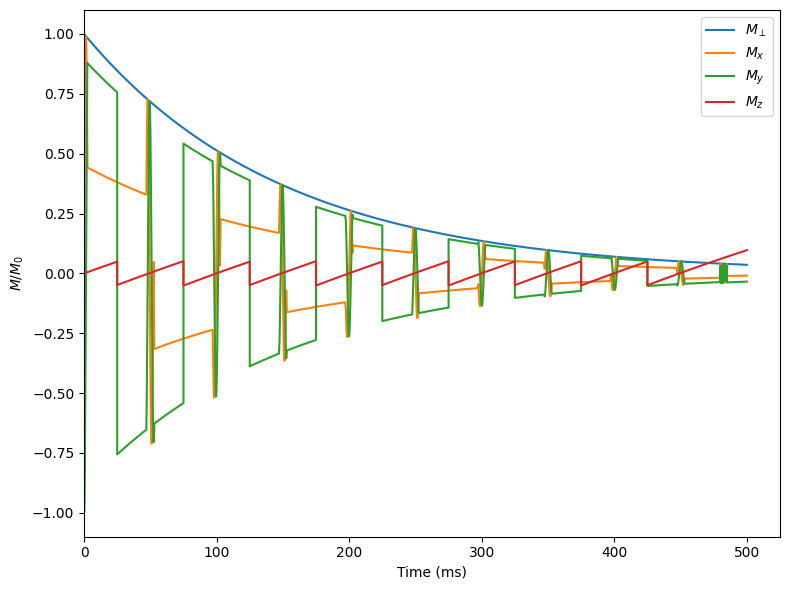

In [6]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.tight_layout()

In [7]:
transverse_mag = (voxel[..., 0] + 1j * voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = voxel[..., 2].mean(axis=(0, 1))

In [9]:
x_axis[transverse_mag.imag.argmax()]

50.000000000000405

In [10]:
TE

0.05 [ T ]

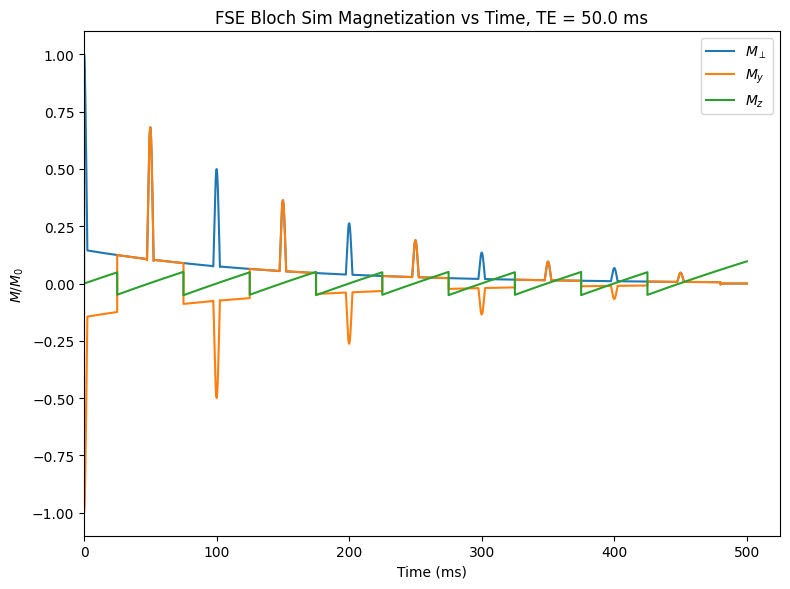

In [11]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title(f'FSE Bloch Sim Magnetization vs Time, TE = {TE.convert_to(ms)} ms')
plt.tight_layout()
plt.savefig('figures/FSE Bloch Sim Magnetization vs Time.png')

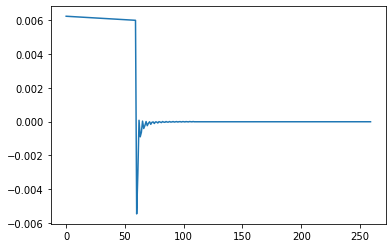

In [12]:
plt.plot(transverse_mag.imag[-260:])

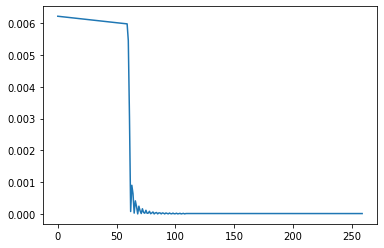

In [13]:
plt.plot(np.abs(transverse_mag[-260:]))